In [35]:
from sklearn import datasets
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib

In [398]:

# Model:
#  Input Layer
#  Hidden Layer 100
#  ReLu
#  Hidden Layer 100
#  ReLu
#  Output Layer 2
model = Sequential([
    Dense(75, activation='relu', input_shape=(2,)),
    #Dense(25, activation='relu'),
    Dense(2)
])

optimizer = Adam(learning_rate=0.01)

In [399]:
dim = 2
# More noise in the moons makes the task harder
X, y = datasets.make_moons(n_samples=2000, shuffle=True, noise=.02)
# Rescale and shift the dataset to better fit into zero-one box
X = (X + 1.6) / 4
X[:, 0] = X[:, 0] - 0.035
X[:, 1] = (X[:, 1] - 0.17) * 1.75

In [400]:
X_test, y_test = datasets.make_moons(n_samples=400, shuffle=True, noise=.02)
X_test = (X_test + 1.6) / 4
X_test[:, 0] = X_test[:, 0] - 0.035
X_test[:, 1] = (X_test[:, 1] - 0.17) * 1.75

In [401]:
y = tf.one_hot(y, dim)

In [402]:
#y_test = tf.one_hot(y_test, dim)

In [403]:
def cross_ent(logits, y):
    losses = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
    return tf.reduce_mean(losses)


def max_conf(logits):
    y = tf.argmax(logits, 1)
    y = tf.one_hot(y, dim)
    losses = -tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
    return tf.reduce_mean(losses)

In [404]:
def gen_adv(x):
    eps = 0.025
    n_iters = 4
    step_size = 0.02

    unif = tf.random.uniform(minval=-eps, maxval=eps, shape=tf.shape(x))
    x_adv = tf.clip_by_value(x + unif, 0., 1.)
    
    for i in range(n_iters):
        x_adv = tf.Variable(x_adv)
        with tf.GradientTape() as tape:
            loss = max_conf(model(x_adv))
            grad = tape.gradient(loss, x_adv)
            g = tf.sign(grad)

        x_adv_start = x_adv + step_size*g
        x_adv = tf.clip_by_value(x_adv, 0., 1.)
        delta = x_adv - x_adv_start
        delta = tf.clip_by_value(delta, -eps, eps)
        x_adv = x_adv_start + delta

    return x_adv

In [405]:
acet = True

In [406]:
if acet:
    n_iter = 600
else:
    n_iter = 200

In [407]:
# Custom training cycle going through the entire dataset
for epoch in range(1, n_iter+1):
    X_noise = tf.random.uniform([2*X.shape[0], X.shape[1]])
    # If we use the ACET method, then adversarial noise will be generated
    if acet:
        X_noise = gen_adv(X_noise)
    # Context used to calculate the gradients of the model
    with tf.GradientTape() as tape:
        logits = model(X)
        logits_noise = model(X_noise)
        loss_main = cross_ent(logits, y)
        loss_acet = acet * max_conf(logits_noise)
        loss = loss_main + loss_acet
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 100  == 0:
        train_err = np.mean(logits.numpy().argmax(1) != y.numpy().argmax(1))
        print("Iter {:03d}: loss_main={:.3f} loss_acet={:.3f} err={:.2%}"
              .format(epoch, loss_main, loss_acet, train_err))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Iter 100: loss_main=0.568 loss_acet=-0.583 err=13.60%
Iter 200: loss_main=0.447 loss_acet=-0.475 err=12.90%
Iter 300: loss_main=0.430 loss_acet=-0.475 err=12.55%
Iter 400: loss_main=0.406 loss_acet=-0.460 err=12.85%
Iter 500: loss_main=0.401 loss_acet=-0.466 err=12.65%
Iter 600: loss_main=0.423 loss_acet=-0.499 err=12.80%


In [408]:
test_accuracy = tf.keras.metrics.Accuracy()


for idx in range(len(X_test)):
    sample_test = X_test[idx]
    target_test = y_test[idx]

    # Adding batch dim since batch=1
    sample_test = np.expand_dims(sample_test, axis=0)
    target_test = np.expand_dims(target_test, axis=0)

    # To tensors
    sample_test = K.constant(sample_test)
    target_test = K.constant(target_test)
        
    logits = model(sample_test)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    #print(prediction.shape)
    #print(target_test.shape)
    test_accuracy(prediction, target_test)
    

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 87.000%


In [23]:
def plot(model, plot_min, plot_max, max_prob):
    n_grid = 200
    x_plot = np.linspace(plot_min, plot_max, n_grid)
    y_plot = np.linspace(plot_min, plot_max, n_grid)
    
    points = []
    for xx in x_plot:
        for yy in y_plot:
            points.append((yy, xx))
    points = np.array(points)
    
    logits = model(points)
    probs = tf.nn.softmax(logits).numpy()
    if max_prob:
        z_plot = probs.max(1)
    else:
        z_plot = probs[:, 0]
    z_plot = z_plot.reshape(len(x_plot), len(y_plot)) * 100
    
    ax = plt.gca()
    
    vmax = 100
    vmin = 50 if max_prob else 0
    plt.contourf(x_plot, y_plot, z_plot, levels=np.linspace(50, 100, 50))
    cbar = plt.colorbar(ticks=np.linspace(vmin, vmax, 6))
    
    cbar.ax.set_title('confidence', fontsize=12, pad=12)
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%', '100%'])
    
    y_np = np.array(y)
    X0 = X[y_np.argmax(1)==0]
    X1 = X[y_np.argmax(1)==1]
    plt.scatter(X0[:, 0], X0[:, 1], s=20, edgecolors='red', facecolor='None',
                marker='o', linewidths=0.2)
    plt.scatter(X1[:, 0], X1[:, 1], s=20, edgecolors='green', facecolor='None',
                marker='s', linewidths=0.2)
    plt.xlim([plot_min, plot_max])
    plt.ylim([plot_min, plot_max])
    
    margin = 0.01
    rect = matplotlib.patches.Rectangle((-margin, -margin), 1.0+2*margin, 1.0+2*margin, 
                                        linewidth=1.5, color='white', fill=False)
    ax.add_patch(rect)
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('plots/base_acet={}_{:.1f}_{:.1f}_max_prob={}.pdf'.format(
        acet, plot_min, plot_max, max_prob), transparent=True)
    plt.show()

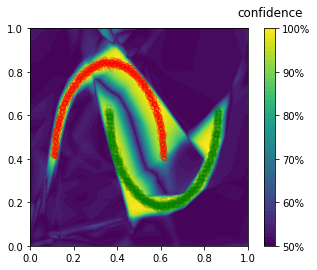

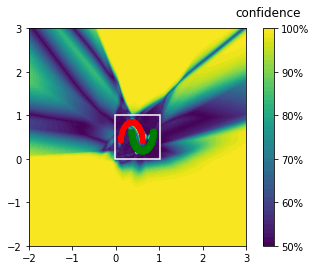

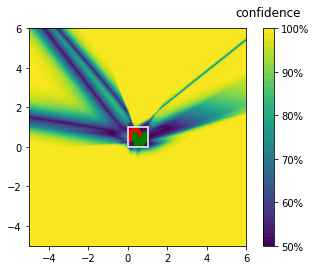

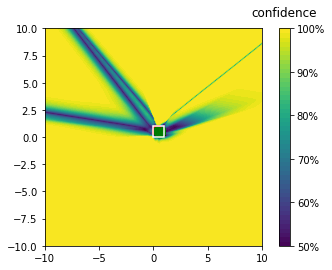

In [24]:
plot(model, 0.0, 1.0, max_prob=True)
plot(model, -2.0, 3.0, max_prob=True)
plot(model, -5.0, 6.0, max_prob=True)
plot(model, -10.0, 10.0, max_prob=True)